# distilEfficientFaceNet

In [1]:
import os, io, copy
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [2]:
MODEL_NAME = 'distilEfficientFaceNet - run6'

IMG_SHAPE = (224, 224, 3)
IMG_SIZE = IMG_SHAPE[:-1]

TEST_SIZE = 0.1
VAL_SIZE = 0.1

BATCH_SIZE = 64
EPOCHS = 100
INITIAL_LR = 1e-3

BASE_PATH = 'C:/Users/ngwei/Desktop/ITI110 Deep Learning Project'
DATASET_PATH = os.path.join(BASE_PATH, 'data', 'main')
FACENET_EMBEDDING_PATH = os.path.join(BASE_PATH, 'data', 'facenet_embedding')
MODEL_RUN_PATH = os.path.join(BASE_PATH, 'models', MODEL_NAME)
TB_LOG_PATH = os.path.join(BASE_PATH, 'tb_logs', MODEL_NAME)

if not os.path.isdir(MODEL_RUN_PATH):
    os.mkdir(MODEL_RUN_PATH)

In [3]:
def plot_history(history, save_path=''):
    
    plt.style.use("ggplot")
    plt.figure(figsize=(20,6))
    
    # summarize history for loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="train")
    plt.plot(history.history['val_loss'], label="val")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    
    # summarize history for cosine similarity
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label="train")
    plt.plot(history.history['val_mse'], label="val")
    plt.title("Model MSE")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='upper left')
    
    if save_path:
        plt.savefig(save_path)

In [4]:
def load_data(path=DATASET_PATH, test_size=TEST_SIZE, val_size=VAL_SIZE):
    
    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
    folders = glob(path+'/*')
    
    # to ensure similar distribution of number of images per class
    def get_folder_size_bins(folders):
        folders_size = [len(os.listdir(folder)) for folder in folders]
        qcut_list = list(pd.qcut(folders_size, 10, duplicates='drop'))
        return qcut_list
    
    test_qualified_folders = [folder for folder in folders if len(os.listdir(folder)) >= 2]
    folders_size_bins = get_folder_size_bins(test_qualified_folders)
    train_folders, test_folders = train_test_split(test_qualified_folders, stratify=folders_size_bins,
                                                   test_size=test_size, random_state=1234)
    
    folders_size_bins = get_folder_size_bins(train_folders)
    train_folders, val_folders = train_test_split(train_folders, stratify=folders_size_bins,
                                                  test_size=val_size, random_state=1234)
    
    label, lbl2name = 0, dict()
    for folder in train_folders:
        files = glob(folder+'/*')
        X_train.extend(files)
        y_train.extend([label] * len(files))
        lbl2name[label] = os.path.basename(folder)
        label += 1
    for folder in val_folders:
        files = glob(folder+'/*')
        X_val.extend(files)
        y_val.extend([label] * len(files))
        lbl2name[label] = os.path.basename(folder)
        label += 1
    for folder in test_folders:
        files = glob(folder+'/*')
        X_test.extend(files)
        y_test.extend([label] * len(files))
        lbl2name[label] = os.path.basename(folder)
        label += 1
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    print('Train:')
    print('\t Number of Classes:', len(train_folders))
    print('\t Number of Images: ', len(y_train), '\n')
    print('Val:')
    print('\t Number of Classes:', len(val_folders))
    print('\t Number of Images: ', len(y_val), '\n')
    print('Test:')
    print('\t Number of Classes:', len(test_folders))
    print('\t Number of Images: ', len(y_test), '\n')
    print('-'*50)
    print('Total:')
    print('\t Number of Classes:', len(train_folders)+len(val_folders)+len(test_folders))
    print('\t Number of Images: ', len(y_train)+len(y_val)+len(y_test))
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), lbl2name


(X_train_paths, y_train_labels), (X_val_paths, y_val_labels), (X_test_paths, y_test_labels), lbl2name = load_data()

Train:
	 Number of Classes: 1436
	 Number of Images:  21135 

Val:
	 Number of Classes: 160
	 Number of Images:  2759 

Test:
	 Number of Classes: 178
	 Number of Images:  2742 

--------------------------------------------------
Total:
	 Number of Classes: 1774
	 Number of Images:  26636


In [5]:
def image_preprocessing(path):
    image = Image.open(path).resize(IMG_SIZE)
    image = np.asarray(image).astype("float32")
    image = preprocess_input(image, data_format='channels_last')
    return image

def get_images_from_paths(img_paths, image_preprocessing_fn=image_preprocessing):
    images = [image_preprocessing_fn(path) for path in img_paths]
    return np.array(images, dtype='float32')

def image_facenet_preprocessing(path):
    image = Image.open(path).resize((160, 160))
    image = np.asarray(image).astype("float32")
    image = (image * 2/255) - 1
    return image

def get_facenet_embedding_from_paths(img_paths):
    embeddings = [np.load(f'{path[:-4]}.npy') for path in img_paths]
    return np.array(embeddings, dtype='float32')

In [6]:
def generate_data(val=False):
    img_paths = copy.deepcopy(X_val_paths) if val else copy.deepcopy(X_train_paths)
    
    while True:
        # shuffle
        np.random.shuffle(img_paths)

        for batch_start_i in range(0, len(img_paths), BATCH_SIZE):
            batch_img_paths = img_paths[batch_start_i:batch_start_i+BATCH_SIZE]
            batch_emb_paths = [os.path.join(FACENET_EMBEDDING_PATH, *img_path.split('\\')[-2:]) for img_path in batch_img_paths]
            
            batch_images = get_images_from_paths(batch_img_paths)
            batch_facenet_embeddings = get_facenet_embedding_from_paths(batch_emb_paths)
            yield batch_images, batch_facenet_embeddings

train_generator = generate_data()
val_generator = generate_data(val=True)

In [7]:
def build_EfficientFaceNet(pretrained_path=''):
    
    Inp = tf.keras.layers.Input(IMG_SHAPE, name='input')
    base_model = EfficientNetB0(include_top=False, input_tensor=Inp, drop_connect_rate=0.5)
    
    x = base_model.output
    x = tf.keras.layers.Dropout(0.5, name='dropout1')(x)
    x = tf.keras.layers.DepthwiseConv2D((7,7), name='glb_depth_conv')(x)
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dropout(0.5, name='dropout2')(x)
    x = tf.keras.layers.Dense(128, name='non_norm_emb')(x)
    Out = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='norm_emb')(x)
    
    EfficientFaceNet = tf.keras.models.Model(inputs=Inp,
                                             outputs=Out,
                                             name='EfficientFaceNet')
    if pretrained_path:
        EfficientFaceNet.load_weights(pretrained_path)
        
    return EfficientFaceNet

In [8]:
def get_report(model, image_preprocessing_fn, paths, labels):
    
    images = get_images_from_paths(paths, image_preprocessing_fn=image_preprocessing_fn)
    embeddings = model.predict(images)

    registered_embeddings, registered_labels = [], []
    webcam_embeddings, webcam_actual_labels = [], []
    col2label = dict()

    for embedding, label in zip(embeddings, labels):
        if label not in registered_labels:
            registered_embeddings.append(embedding)
            registered_labels.append(label)
            col2label[len(col2label)] = label
        else:
            webcam_embeddings.append(embedding)
            webcam_actual_labels.append(label)
    
    cosine_similarities = np.matmul(webcam_embeddings, np.transpose(registered_embeddings))

    webcam_predicted_col = np.argmax(cosine_similarities, axis=1)
    webcam_predicted_labels = list(map(lambda col: col2label[col], webcam_predicted_col))

    webcam_actual_names = list(map(lambda lbl: lbl2name[lbl], webcam_actual_labels))
    webcam_predicted_names = list(map(lambda lbl: lbl2name[lbl], webcam_predicted_labels))
    
    print(classification_report(webcam_actual_names, webcam_predicted_names))

# Training

In [9]:
EfficientFaceNet = build_EfficientFaceNet()
EfficientFaceNet.summary()

Model: "EfficientFaceNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________________________________________________________________

In [10]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=f'{TB_LOG_PATH}'),
    tf.keras.callbacks.CSVLogger(os.path.join(MODEL_RUN_PATH, 'training.log')),
]

In [11]:
EfficientFaceNet.compile(
    optimizer = tf.keras.optimizers.Adam(INITIAL_LR),
    loss = 'cosine_similarity',
    metrics = ['mse'],
)

In [12]:
EfficientFaceNet.fit(
    train_generator,
    validation_data = val_generator,
    epochs = EPOCHS,
    steps_per_epoch = np.ceil(len(X_train_paths) / BATCH_SIZE),
    validation_steps = np.ceil(len(X_val_paths) / BATCH_SIZE),
    callbacks = callbacks,
    verbose = 1,
)

C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
331/331 [==============================] - 173s 496ms/step - loss: -0.4040 - mse: 0.9976 - val_loss: -0.5047 - val_mse: 0.9785
Epoch 2/100
331/331 [==============================] - 163s 491ms/step - loss: -0.6507 - mse: 0.9527 - val_loss: -0.6435 - val_mse: 0.9532
Epoch 3/100
331/331 [==============================] - 160s 484ms/step - loss: -0.7411 - mse: 0.9362 - val_loss: -0.7005 - val_mse: 0.9441
Epoch 4/100
331/331 [==============================] - 161s 485ms/step - loss: -0.7856 - mse: 0.9281 - val_loss: -0.7322 - val_mse: 0.9354
Epoch 5/100
331/331 [==============================] - 161s 485ms/step - loss: -0.8111 - mse: 0.9235 - val_loss: -0.7726 - val_mse: 0.9303
Epoch 6/100
331/331 [==============================] - 159s 482ms/step - loss: -0.8279 - mse: 0.9204 - val_loss: -0.7889 - val_mse: 0.9267
Epoch 7/100
331/331 [==============================] - 160s 483ms/step - loss: -0.8408 - mse: 0.9180 - val_loss: -0.7985 - val_mse: 0.9231
Epoch 8/100
331/331 [======

Epoch 58/100
331/331 [==============================] - 161s 487ms/step - loss: -0.9471 - mse: 0.8986 - val_loss: -0.8815 - val_mse: 0.9104

Epoch 00058: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 59/100
331/331 [==============================] - 159s 481ms/step - loss: -0.9478 - mse: 0.8985 - val_loss: -0.8808 - val_mse: 0.9096
Epoch 60/100
331/331 [==============================] - 160s 482ms/step - loss: -0.9482 - mse: 0.8984 - val_loss: -0.8823 - val_mse: 0.9096
Epoch 61/100
331/331 [==============================] - 160s 484ms/step - loss: -0.9482 - mse: 0.8984 - val_loss: -0.8819 - val_mse: 0.9094
Epoch 62/100
331/331 [==============================] - 160s 483ms/step - loss: -0.9483 - mse: 0.8984 - val_loss: -0.8806 - val_mse: 0.9095
Epoch 63/100
331/331 [==============================] - 160s 483ms/step - loss: -0.9484 - mse: 0.8984 - val_loss: -0.8832 - val_mse: 0.9074
Epoch 64/100
331/331 [==============================] - 160s 483ms/step - loss: 

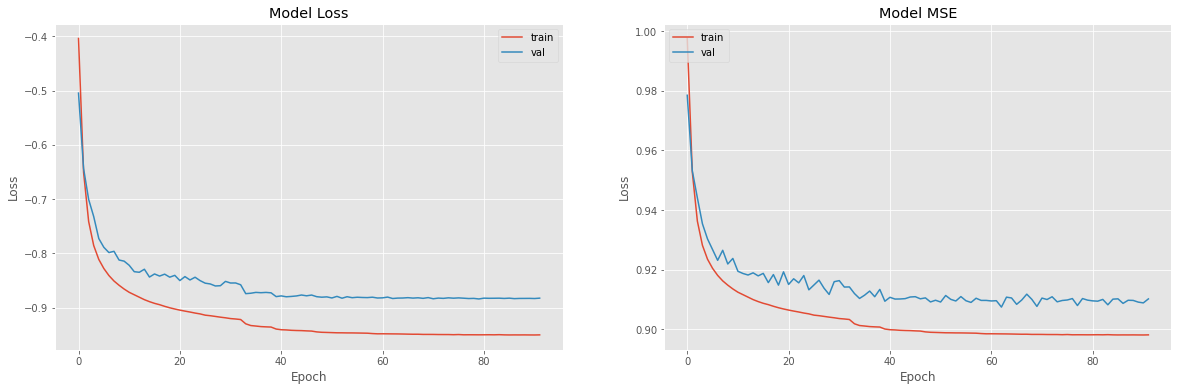

In [13]:
plot_history(EfficientFaceNet.history, os.path.join(MODEL_RUN_PATH, f'training_plot_{MODEL_NAME}'))

In [14]:
EfficientFaceNet.save_weights(os.path.join(MODEL_RUN_PATH, f'savedweights_{MODEL_NAME}'))

# Validation

In [15]:
EfficientFaceNet = build_EfficientFaceNet()
EfficientFaceNet.load_weights(os.path.join(MODEL_RUN_PATH, f'savedweights_{MODEL_NAME}'))

In [16]:
get_report(EfficientFaceNet, image_preprocessing, X_val_paths, y_val_labels)

                       precision    recall  f1-score   support

    alastair_campbell       1.00      1.00      1.00         4
         alice_fisher       1.00      1.00      1.00         1
        allyson_felix       1.00      1.00      1.00         4
alvaro_silva_calderon       0.33      1.00      0.50         3
         alvaro_uribe       1.00      0.88      0.94        34
anders_fogh_rasmussen       0.30      1.00      0.46         3
         andrew_cuomo       0.33      1.00      0.50         1
          ann_veneman       0.77      1.00      0.87        10
       annette_bening       0.06      1.00      0.12         1
      anthony_hopkins       0.33      1.00      0.50         1
     antonio_banderas       1.00      0.25      0.40         4
arnold_schwarzenegger       1.00      0.63      0.78        41
     aung_san_suu_kyi       0.50      1.00      0.67         1
           barry_zito       0.00      0.00      0.00         1
          ben_howland       1.00      1.00      1.00  

C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Embedding Projection

In [17]:
EfficientFaceNet = build_EfficientFaceNet()
EfficientFaceNet.load_weights(os.path.join(MODEL_RUN_PATH, f'savedweights_{MODEL_NAME}'))

In [18]:
# https://projector.tensorflow.org/

# Evaluate the network
np.random.seed(1234)
labels, counts = np.unique(y_val_labels, return_counts=True)
candidates_sample_labels = [lbl for lbl, cnt in zip(labels, counts) if cnt >= 10]
selected_sample_labels = np.random.choice(candidates_sample_labels, 10, replace=False)

X_sample_paths = [path for path, label in zip(X_val_paths, y_val_labels) if label in selected_sample_labels]
y_sample_labels = [label for label in y_val_labels if label in selected_sample_labels]

sample_images = get_images_from_paths(X_sample_paths)
val_results = EfficientFaceNet.predict(sample_images)

# Save test embeddings for visualization in projector
np.savetxt(os.path.join(MODEL_RUN_PATH, f'val_embedding_results_{MODEL_NAME}.tsv'), val_results, delimiter='\t')

out_m = io.open(os.path.join(MODEL_RUN_PATH, f'val_embedding_meta_{MODEL_NAME}.tsv'), 'w', encoding='utf-8')
for img, label in zip(sample_images, y_sample_labels):
    [out_m.write(str(lbl2name[label]) + "\n")]
out_m.close()

# Testing

In [19]:
EfficientFaceNet = build_EfficientFaceNet()
EfficientFaceNet.load_weights(os.path.join(MODEL_RUN_PATH, f'savedweights_{MODEL_NAME}'))

In [20]:
get_report(EfficientFaceNet, image_preprocessing, X_test_paths, y_test_labels)

                              precision    recall  f1-score   support

         abdel_nasser_assidi       0.00      0.00      0.00         1
                    abdullah       0.43      1.00      0.60         3
            abdullatif_sener       0.20      1.00      0.33         1
abid_hamid_mahmud_al_tikriti       0.50      1.00      0.67         2
              adrian_nastase       0.33      1.00      0.50         1
                adrien_brody       0.83      0.91      0.87        11
                   al_pacino       0.67      1.00      0.80         2
                alan_mulally       0.25      1.00      0.40         1
                albert_costa       0.67      0.80      0.73         5
                   alex_sink       1.00      1.00      1.00         2
                 amanda_crew       0.94      0.97      0.95       116
               amer_al_saadi       1.00      1.00      1.00         3
                amram_mitzna       0.00      0.00      0.00         1
                and

C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Compare with Facenet

In [21]:
FaceNet = tf.keras.models.load_model(os.path.join(BASE_PATH, 'models', 'FaceNet', 'facenet_model'))

C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\keras\layers\core.py:1043: UserWarning: keras.layers.core.lambda_layer is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


In [22]:
get_report(FaceNet, image_facenet_preprocessing, X_test_paths, y_test_labels)

                              precision    recall  f1-score   support

         abdel_nasser_assidi       0.00      0.00      0.00         1
                    abdullah       0.75      1.00      0.86         3
            abdullatif_sener       0.11      1.00      0.20         1
abid_hamid_mahmud_al_tikriti       1.00      1.00      1.00         2
              adrian_nastase       1.00      1.00      1.00         1
                adrien_brody       1.00      0.91      0.95        11
                   al_pacino       0.33      1.00      0.50         2
                alan_mulally       0.50      1.00      0.67         1
                albert_costa       1.00      1.00      1.00         5
                   alex_sink       0.50      1.00      0.67         2
                 amanda_crew       0.99      0.97      0.98       116
               amer_al_saadi       0.75      1.00      0.86         3
                amram_mitzna       0.00      0.00      0.00         1
                and

C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ngwei\anaconda3\envs\tf2.6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
